In [2]:
!pip install biosppy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 16.1 MB/s 


In [2]:
#importing the libraries
import numpy as np
import pandas as pd 
import sklearn 
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import scipy
from scipy import signal
from biosppy.signals import ecg 
from biosppy.signals import eeg
from biosppy.signals import resp
from scipy.interpolate import interp1d 
import matplotlib.pyplot as plt
import tqdm 
from tqdm import tqdm
from IPython.core.display import display, HTML

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_data=pd.read_csv("/content/drive/MyDrive/AviationFatalities/train.csv")
print('Train Data Shape ---->',train_data.shape)
print("\n")
test_data=pd.read_csv("/content/drive/MyDrive/AviationFatalities/test.csv")
print('Test Data Shape ----->',test_data.shape)

print("Train Data Columns ==> "+train_data.columns)

Train Data Shape ----> (4867421, 28)


Test Data Shape -----> (17965143, 28)
Index(['Train Data Columns ==> crew', 'Train Data Columns ==> experiment',
       'Train Data Columns ==> time', 'Train Data Columns ==> seat',
       'Train Data Columns ==> eeg_fp1', 'Train Data Columns ==> eeg_f7',
       'Train Data Columns ==> eeg_f8', 'Train Data Columns ==> eeg_t4',
       'Train Data Columns ==> eeg_t6', 'Train Data Columns ==> eeg_t5',
       'Train Data Columns ==> eeg_t3', 'Train Data Columns ==> eeg_fp2',
       'Train Data Columns ==> eeg_o1', 'Train Data Columns ==> eeg_p3',
       'Train Data Columns ==> eeg_pz', 'Train Data Columns ==> eeg_f3',
       'Train Data Columns ==> eeg_fz', 'Train Data Columns ==> eeg_f4',
       'Train Data Columns ==> eeg_c4', 'Train Data Columns ==> eeg_p4',
       'Train Data Columns ==> eeg_poz', 'Train Data Columns ==> eeg_c3',
       'Train Data Columns ==> eeg_cz', 'Train Data Columns ==> eeg_o2',
       'Train Data Columns ==> ecg', 'Train Da

##1) Deriving Heart Beat Information From ECG

In [5]:
#ecg.ecg is the function inside the biosppy module to get more useful information from the ecg data
ecg_bio_ca=ecg.ecg(train_data[train_data["experiment"]=="CA"]["ecg"],sampling_rate=256,show=False)
ecg_bio_da=ecg.ecg(train_data[train_data["experiment"]=="DA"]["ecg"],sampling_rate=256,show=False)
ecg_bio_ss=ecg.ecg(train_data[train_data["experiment"]=="SS"]["ecg"],sampling_rate=256,show=False)
print(ecg_bio_ca.keys())#this gives the features provided by the function
print(ecg_bio_ca["heart_rate_ts"].shape)

['ts', 'filtered', 'rpeaks', 'templates_ts', 'templates', 'heart_rate_ts', 'heart_rate']
(5486,)


In [6]:
print(ecg_bio_ca['ts'].shape)
print(ecg_bio_ca['filtered'].shape)
print(ecg_bio_ca['rpeaks'].shape)
print(ecg_bio_ca['templates_ts'].shape)
print(ecg_bio_ca['templates'].shape)
print(ecg_bio_ca['heart_rate_ts'].shape)
print(ecg_bio_ca['heart_rate'].shape)

(1658376,)
(1658376,)
(7184,)
(153,)
(7184, 153)
(5486,)
(5486,)




*   The output heart rate from the biosppy module is at some particular timesteps. The heart rate corresponding to all the timestamps in our data set is not available. So we need to find out these values. Interpolation is used for this purpose



In [7]:
#https://www.tutorialspoint.com/python-scipy-interpolate-interp1d
#https://www.w3schools.com/python/scipy/scipy_interpolation.php

#HEre we are finding an interpolation function between heart_rate_ts and heart_rate and find the following output for the timestamps we have.
def interpolation_fn(timestamps,biosppy_ts, biosppy_values):
    interpolation = interp1d(biosppy_ts,biosppy_values, kind="linear", fill_value="extrapolate")
    return interpolation(timestamps) 


heart_rate_ca=interpolation_fn(train_data[train_data["experiment"]=="CA"]["time"],ecg_bio_ca["heart_rate_ts"],ecg_bio_ca["heart_rate"])
heart_rate_da=interpolation_fn(train_data[train_data["experiment"]=="DA"]["time"],ecg_bio_da["heart_rate_ts"],ecg_bio_da["heart_rate"])
heart_rate_ss=interpolation_fn(train_data[train_data["experiment"]=="SS"]["time"],ecg_bio_ss["heart_rate_ts"],ecg_bio_ss["heart_rate"])

#Concatenate all the columns
heart_rate=np.concatenate((heart_rate_ca,heart_rate_da,heart_rate_ss))
print(heart_rate.shape)

#Adding new feature in the dataset
train_data["heart_rate"]=heart_rate

(4867421,)


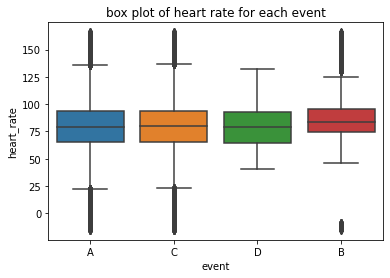

In [8]:
sns.boxplot(train_data["event"],train_data["heart_rate"])
plt.title("box plot of heart rate for each event")
plt.show()



*   There is a lot of noise in Heart Rate.

*   From box plot, we can say that Heart Rate, it is an imp feature and if it is very high, there is a high probabality that it is of class B.



##2) Deriving Respiration Rate Information From respiration( 'r' )

In [9]:
#resp.resp is the function inside the biosppy module to get more useful information from the respiration sensor
r_resp_ca=resp.resp(train_data[train_data["experiment"]=="CA"]["r"],sampling_rate=256,show=False)
r_resp_da=resp.resp(train_data[train_data["experiment"]=="DA"]["r"],sampling_rate=256,show=False)
r_resp_ss=resp.resp(train_data[train_data["experiment"]=="SS"]["r"],sampling_rate=256,show=False)
print(r_resp_ca.keys()) 

#Interpolating respiration rate to get rate in all time stamps
r_resp_ts_ca=interpolation_fn(train_data[train_data["experiment"]=="CA"]["time"],r_resp_ca["resp_rate_ts"],r_resp_ca["resp_rate"])
r_resp_ts_da=interpolation_fn(train_data[train_data["experiment"]=="DA"]["time"],r_resp_da["resp_rate_ts"],r_resp_da["resp_rate"])
r_resp_ts_ss=interpolation_fn(train_data[train_data["experiment"]=="SS"]["time"],r_resp_ss["resp_rate_ts"],r_resp_ss["resp_rate"])

# Adding Respiration Timestamp rate in the dataset
r_resp_ts=np.concatenate((r_resp_ts_ca,r_resp_ts_da,r_resp_ts_ss))
train_data["resp_rate"]=r_resp_ts
print(r_resp_ts.shape)

['ts', 'filtered', 'zeros', 'resp_rate_ts', 'resp_rate']
(4867421,)


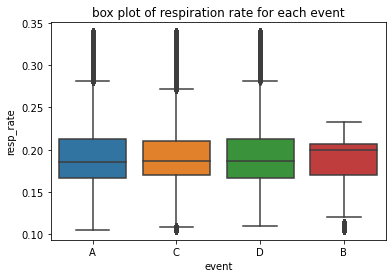

In [10]:
sns.boxplot(train_data["event"],train_data["resp_rate"])
plt.title("box plot of respiration rate for each event")
plt.show()




*   Respiration rate also has many outliers.
*   Respiration rate can't give much detail so this may not be useful to us.




##3) Deriving potential difference from electrodes

In [11]:
# from IPython.display import Image
# Image("3-Figure1-1.png", width=700, height=300)




*   Above figure shows, the different combination of 20 electrodes to calculate the potential difference. For now, we just calculate the potential difference based on the second arrangement. This is because the potential difference from this combination is most commonl used in clinic.


In [12]:
train_data["fp1_f7"]=train_data["eeg_fp1"]-train_data["eeg_f7"]
train_data["f7_t3"]=train_data["eeg_f7"]-train_data["eeg_t3"]
train_data["t3_t5"]=train_data["eeg_t3"]-train_data["eeg_t5"]
train_data["t5_o1"]=train_data["eeg_t5"]-train_data["eeg_o1"]
train_data["p3_o1"]=train_data["eeg_p3"]-train_data["eeg_o1"]
train_data["c3_p3"]=train_data["eeg_c3"]-train_data["eeg_p3"]
train_data["f3_c3"]=train_data["eeg_f3"]-train_data["eeg_c3"]
train_data["fp1_f3"]=train_data["eeg_fp1"]-train_data["eeg_f3"]

train_data["fz_cz"]=train_data["eeg_fz"]-train_data["eeg_cz"]
train_data["cz_pz"]=train_data["eeg_cz"]-train_data["eeg_pz"]

train_data["fp2_f4"]=train_data["eeg_fp2"]-train_data["eeg_f4"]
train_data["f4_c4"]=train_data["eeg_f4"]-train_data["eeg_c4"]
train_data["c4_p4"]=train_data["eeg_c4"]-train_data["eeg_p4"]
train_data["p4_o2"]=train_data["eeg_p4"]-train_data["eeg_o2"]
train_data["t6_o2"]=train_data["eeg_t6"]-train_data["eeg_o2"]
train_data["t4_t6"]=train_data["eeg_t4"]-train_data["eeg_t6"]
train_data["f8_t4"]=train_data["eeg_f8"]-train_data["eeg_t4"]
train_data["fp2_f8"]=train_data["eeg_fp2"]-train_data["eeg_f8"]

##4) Deriving Frequency Bands from EEG data

In [13]:
eeg_features = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1",
                "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"]

In [14]:
eeg_bio_ca=eeg.get_power_features(train_data[train_data["experiment"]=="CA"][eeg_features],sampling_rate=256)
eeg_bio_da=eeg.get_power_features(train_data[train_data["experiment"]=="DA"][eeg_features],sampling_rate=256)
eeg_bio_ss=eeg.get_power_features(train_data[train_data["experiment"]=="SS"][eeg_features],sampling_rate=256)
print(eeg_bio_ca.keys())

print(eeg_bio_ca['theta'][0])

['ts', 'theta', 'alpha_low', 'alpha_high', 'beta', 'gamma']
[0.00596342 0.00315863 0.00877005 0.01876262 0.01764817 0.01551566
 0.02829887 0.0053017  0.01167158 0.03159987 0.00630315 0.00748329
 0.02444151 0.00398584 0.00148314 0.01699546 0.01162901 0.01035285
 0.06036249 0.02282472]


In [15]:
print(len(eeg_bio_ca["ts"]))
print(len(eeg_bio_ca["theta"][:,0]))

51823
51823


In [16]:
# extracting theta band frequency
theta_feature=[]
for i in eeg_features:
    theta_feature.append(i+"_theta")
print(theta_feature)
for i in tqdm(range(20)):
    # we take the theta frequency band and do the interpolation and store the data in the dataframe 
    theta_ca=interpolation_fn(train_data[train_data["experiment"]=="CA"]["time"],eeg_bio_ca["ts"],eeg_bio_ca["theta"][:,i])
    theta_da=interpolation_fn(train_data[train_data["experiment"]=="DA"]["time"],eeg_bio_da["ts"],eeg_bio_da["theta"][:,i])
    theta_ss=interpolation_fn(train_data[train_data["experiment"]=="SS"]["time"],eeg_bio_ss["ts"],eeg_bio_ss["theta"][:,i])

    theta=np.concatenate((theta_ca,theta_da,theta_ss))

    train_data[theta_feature[i]]=theta

['eeg_fp1_theta', 'eeg_f7_theta', 'eeg_f8_theta', 'eeg_t4_theta', 'eeg_t6_theta', 'eeg_t5_theta', 'eeg_t3_theta', 'eeg_fp2_theta', 'eeg_o1_theta', 'eeg_p3_theta', 'eeg_pz_theta', 'eeg_f3_theta', 'eeg_fz_theta', 'eeg_f4_theta', 'eeg_c4_theta', 'eeg_p4_theta', 'eeg_poz_theta', 'eeg_c3_theta', 'eeg_cz_theta', 'eeg_o2_theta']


100%|██████████| 20/20 [01:14<00:00,  3.71s/it]


In [17]:
# extracting alpha_low band frequency
alpha_low_feature=[]
for i in eeg_features:
    alpha_low_feature.append(i+"_alpha_low")
    
for i in tqdm(range(20)):
     # we take the alpha_low frequency band and do the interpolation and store the data in the dataframe 
    alpha_low_ca=interpolation_fn(train_data[train_data["experiment"]=="CA"]["time"],eeg_bio_ca["ts"],eeg_bio_ca["alpha_low"][:,i])
    alpha_low_da=interpolation_fn(train_data[train_data["experiment"]=="DA"]["time"],eeg_bio_da["ts"],eeg_bio_da["alpha_low"][:,i])
    alpha_low_ss=interpolation_fn(train_data[train_data["experiment"]=="SS"]["time"],eeg_bio_ss["ts"],eeg_bio_ss["alpha_low"][:,i])

    alpha_low=np.concatenate((alpha_low_ca,alpha_low_da,alpha_low_ss))

    train_data[alpha_low_feature[i]]=alpha_low    

100%|██████████| 20/20 [01:23<00:00,  4.20s/it]


In [18]:
# extracting alpha_high band frequency
alpha_high_feature=[]
for i in eeg_features:
    alpha_high_feature.append(i+"_alpha_high")
    
for i in tqdm(range(20)):
    # we take the alpha_high frequency band and do the interpolation and store the data in the dataframe 
    alpha_high_ca=interpolation_fn(train_data[train_data["experiment"]=="CA"]["time"],eeg_bio_ca["ts"],eeg_bio_ca["alpha_high"][:,i])
    alpha_high_da=interpolation_fn(train_data[train_data["experiment"]=="DA"]["time"],eeg_bio_da["ts"],eeg_bio_da["alpha_high"][:,i])
    alpha_high_ss=interpolation_fn(train_data[train_data["experiment"]=="SS"]["time"],eeg_bio_ss["ts"],eeg_bio_ss["alpha_high"][:,i])

    alpha_high=np.concatenate((alpha_high_ca,alpha_high_da,alpha_high_ss))

    train_data[alpha_high_feature[i]]=alpha_high   

100%|██████████| 20/20 [01:39<00:00,  4.98s/it]


In [19]:
# extracting beta band frequency
beta_feature=[]
for i in eeg_features:
    beta_feature.append(i+"_beta")
    
for i in tqdm(range(20)):
    # we take the beta frequency band and do the interpolation and store the data in the dataframe 
    beta_ca=interpolation_fn(train_data[train_data["experiment"]=="CA"]["time"],eeg_bio_ca["ts"],eeg_bio_ca["beta"][:,i])
    beta_da=interpolation_fn(train_data[train_data["experiment"]=="DA"]["time"],eeg_bio_da["ts"],eeg_bio_da["beta"][:,i])
    beta_ss=interpolation_fn(train_data[train_data["experiment"]=="SS"]["time"],eeg_bio_ss["ts"],eeg_bio_ss["beta"][:,i])

    beta=np.concatenate((beta_ca,beta_da,beta_ss))

    train_data[beta_feature[i]]=beta    

100%|██████████| 20/20 [02:05<00:00,  6.28s/it]


In [20]:
# extracting gamma band frequency
gamma_feature=[]
for i in eeg_features:
    gamma_feature.append(i+"_gamma")
    
for i in tqdm(range(20)):
    # we take the gamma frequency band and do the interpolation and store the data in the dataframe 
    gamma_ca=interpolation_fn(train_data[train_data["experiment"]=="CA"]["time"],eeg_bio_ca["ts"],eeg_bio_ca["gamma"][:,i])
    gamma_da=interpolation_fn(train_data[train_data["experiment"]=="DA"]["time"],eeg_bio_da["ts"],eeg_bio_da["gamma"][:,i])
    gamma_ss=interpolation_fn(train_data[train_data["experiment"]=="SS"]["time"],eeg_bio_ss["ts"],eeg_bio_ss["gamma"][:,i])

    gamma=np.concatenate((gamma_ca,gamma_da,gamma_ss))

    train_data[gamma_feature[i]]=gamma 

100%|██████████| 20/20 [03:15<00:00,  9.77s/it]


In [21]:
for c in train_data.columns:
  # print(c,end = ", ")
  if(c.__contains__("fp2_")):
    print(c)

fp2_f4
fp2_f8
eeg_fp2_theta
eeg_fp2_alpha_low
eeg_fp2_alpha_high
eeg_fp2_beta
eeg_fp2_gamma


In [22]:
#Giving nos to the output class
d={"A":0,"B":1,"C":2,"D":3}
e=train_data["event"]
e=list(map(lambda i:d[i],e))
train_data["e"]=e


In [23]:
train_data['e'].value_counts()

0    2848809
2    1652686
3     235329
1     130597
Name: e, dtype: int64

##Correlation : removing unimportant features from dataset

###Heatmap of correlation

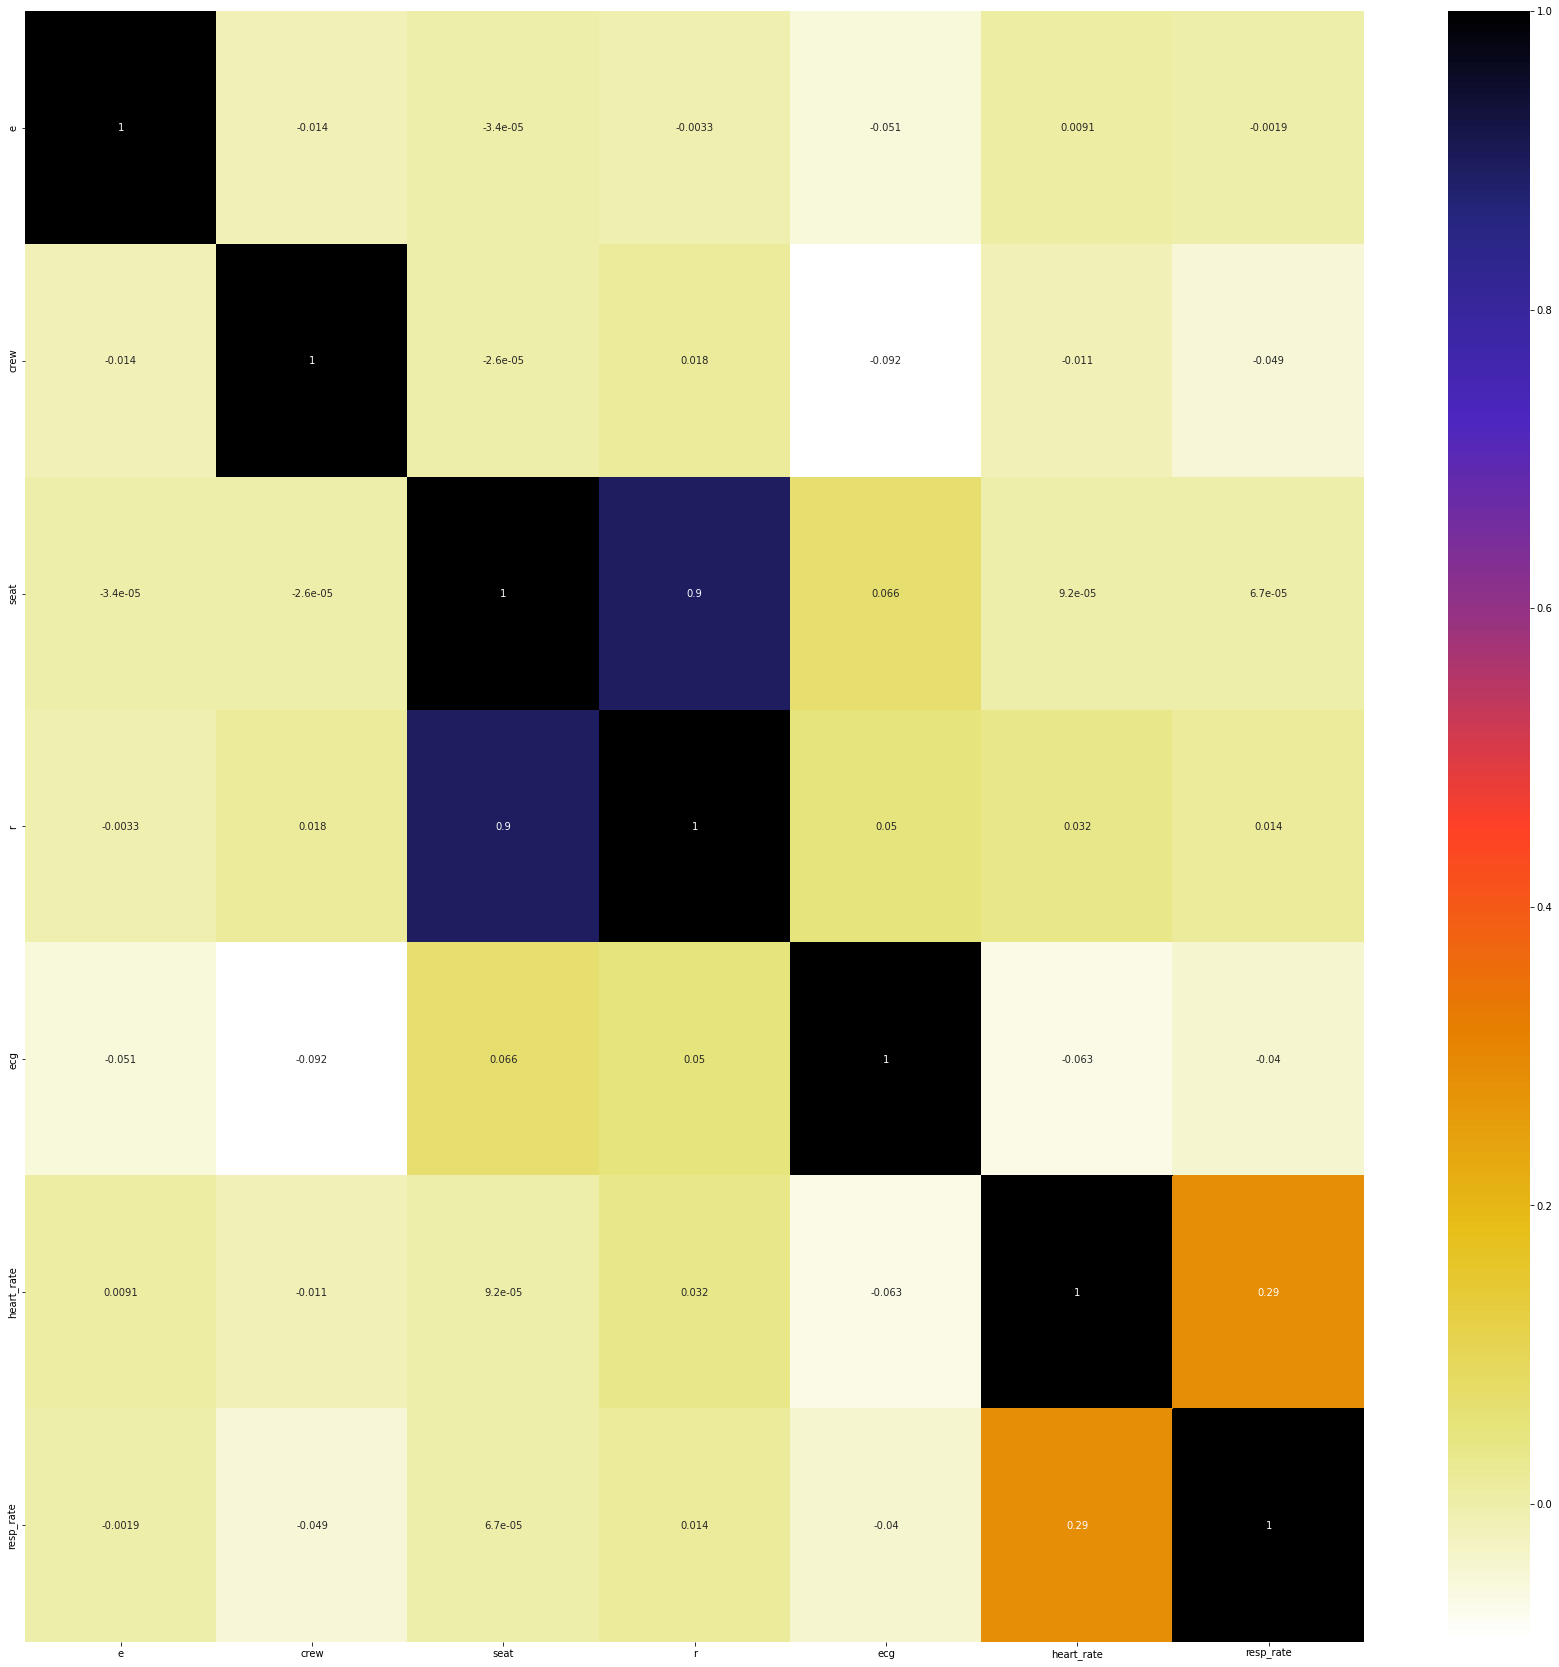

In [107]:
g=["e","crew","seat","r","ecg","heart_rate","resp_rate"]
hm = train_data[g].corr()
plt.figure(figsize=(30,30))
sns.heatmap(hm,annot = True, cmap = plt.cm.CMRmap_r)
plt.show()




*   Probability of crew and ecg is high in predicting the event.
*   Seat feature can be removed as it is very less correlated with event.







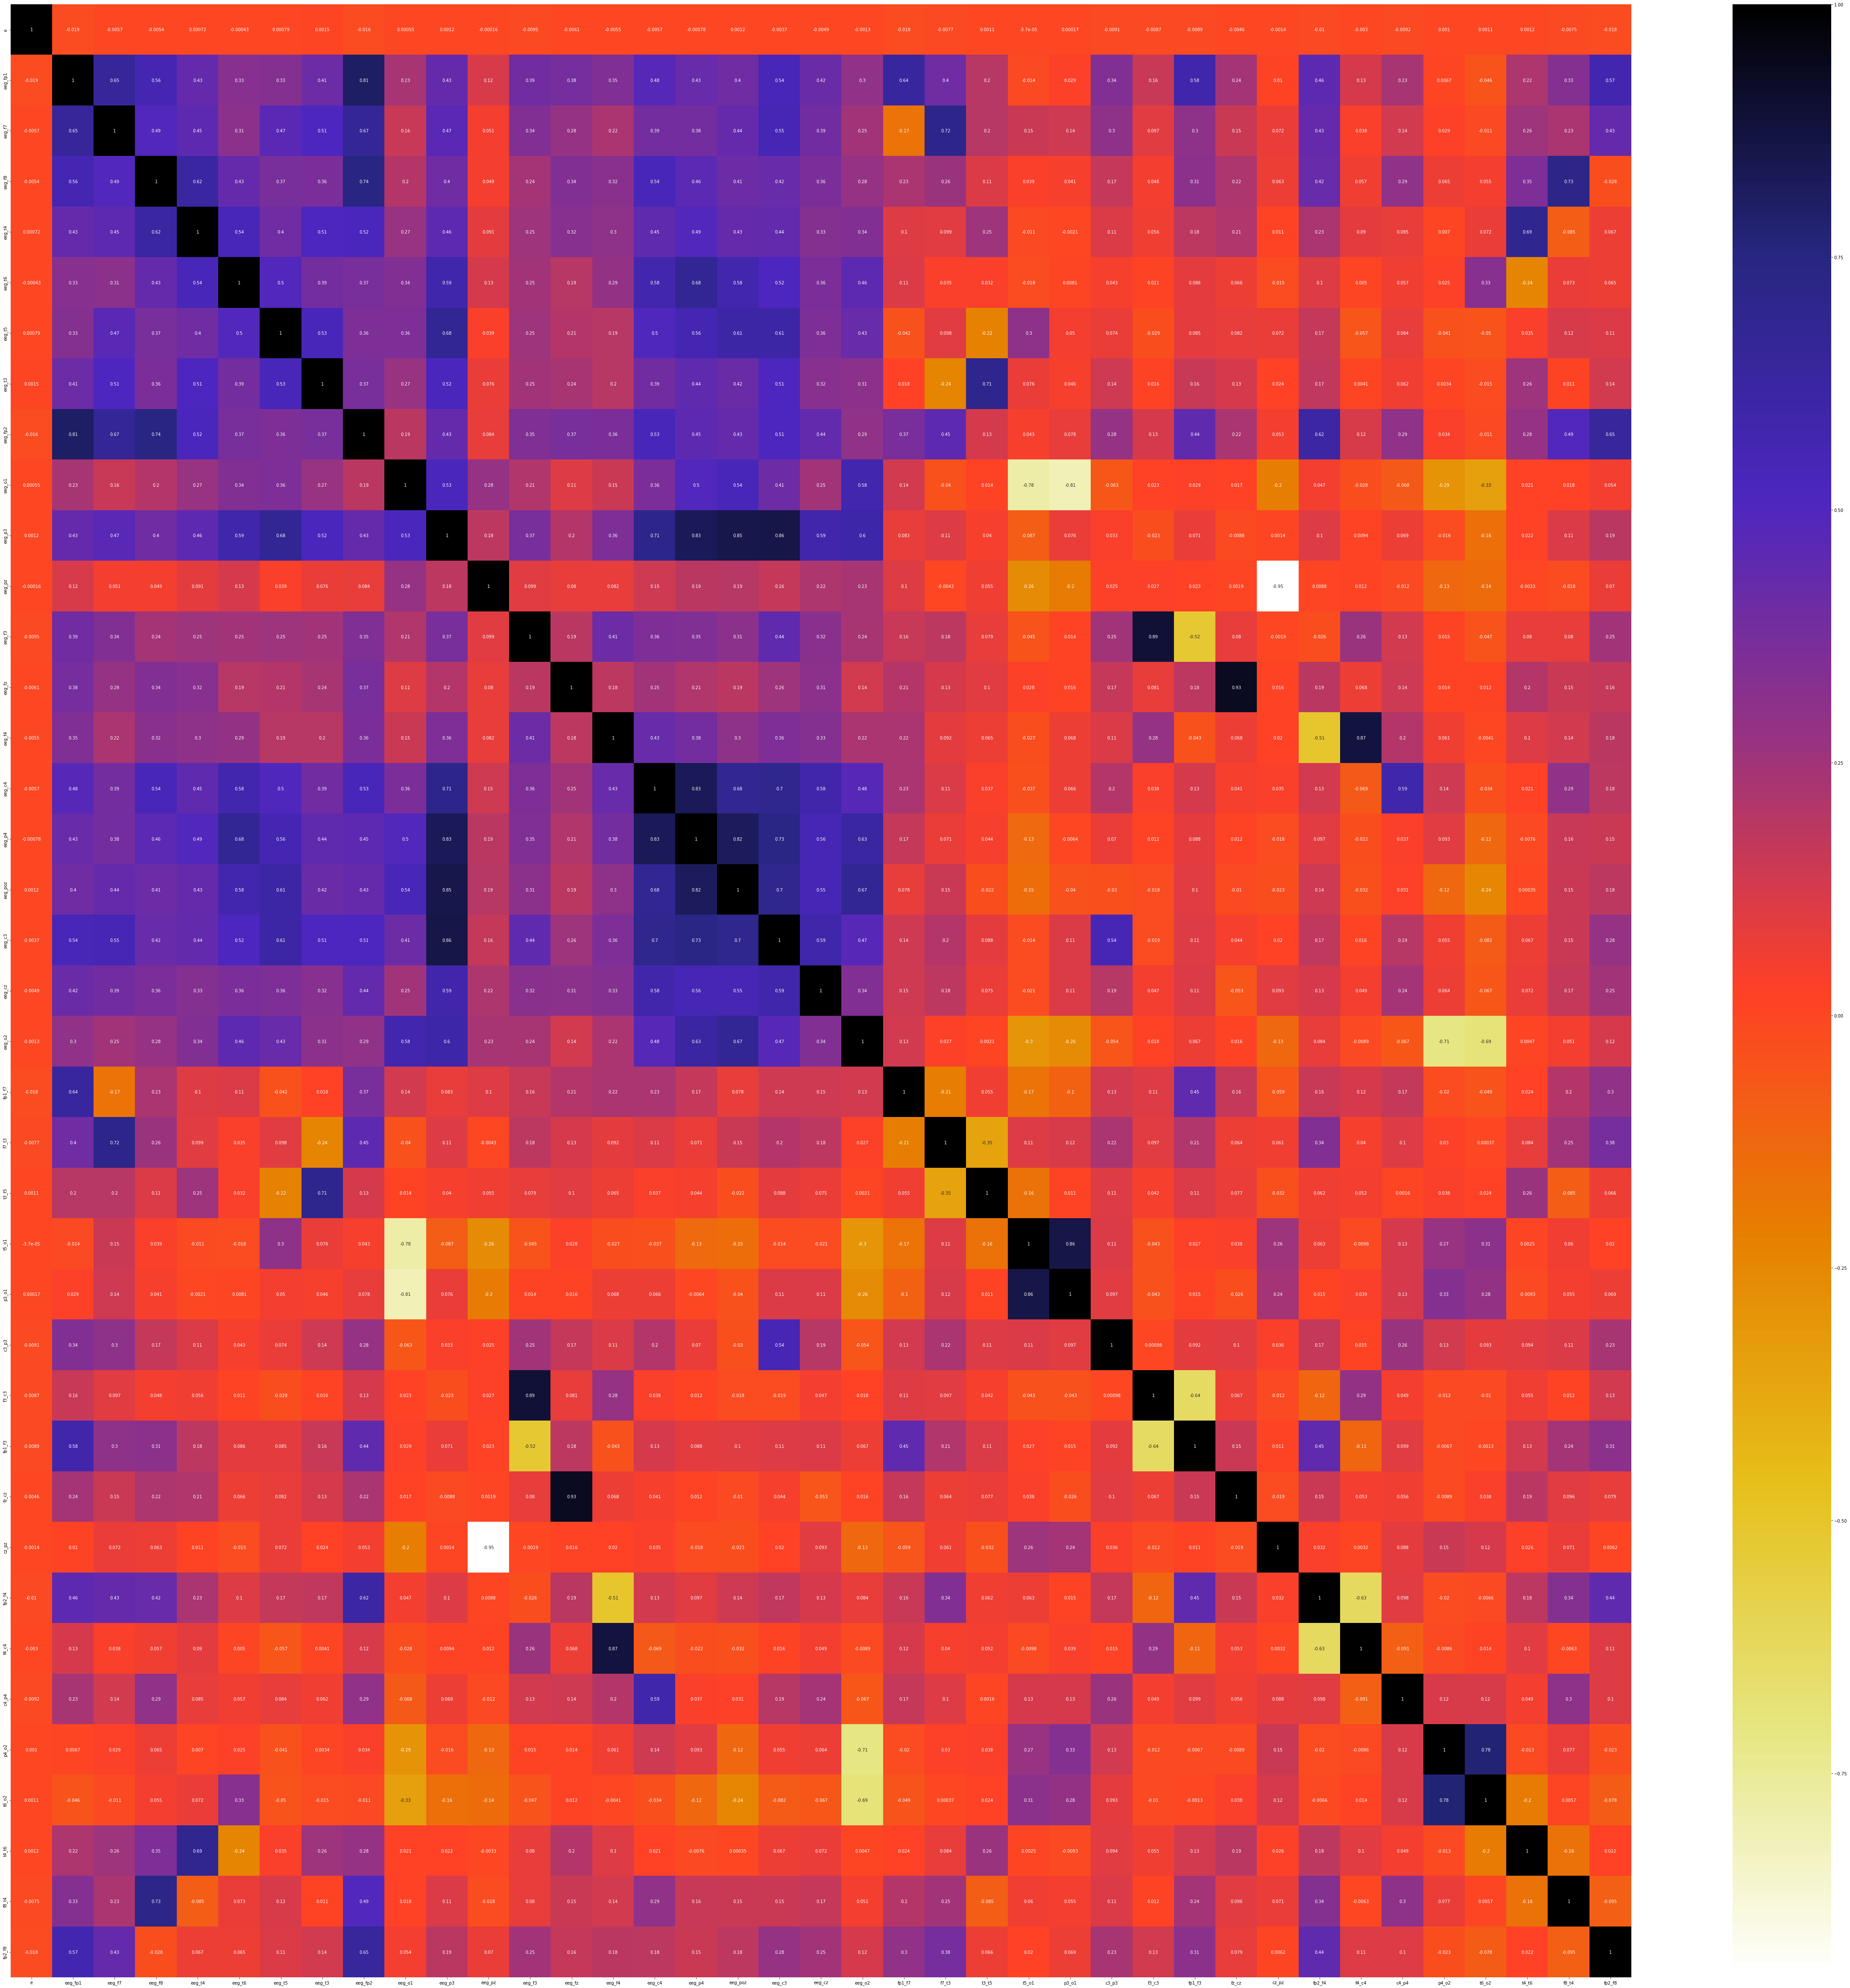

In [100]:
g=["e"]
g.extend(eeg_features)
g.extend(["fp1_f7","f7_t3","t3_t5","t5_o1","p3_o1","c3_p3","f3_c3","fp1_f3","fz_cz",
"cz_pz","fp2_f4","f4_c4","c4_p4","p4_o2","t6_o2","t4_t6","f8_t4","fp2_f8"])
hm = train_data[g].corr()
plt.figure(figsize=(85,85))
sns.heatmap(hm,annot = True, cmap = plt.cm.CMRmap_r)
plt.show()



*   There is not much clarity from here which are not imp, so we'll consider all feature to be imp for now.



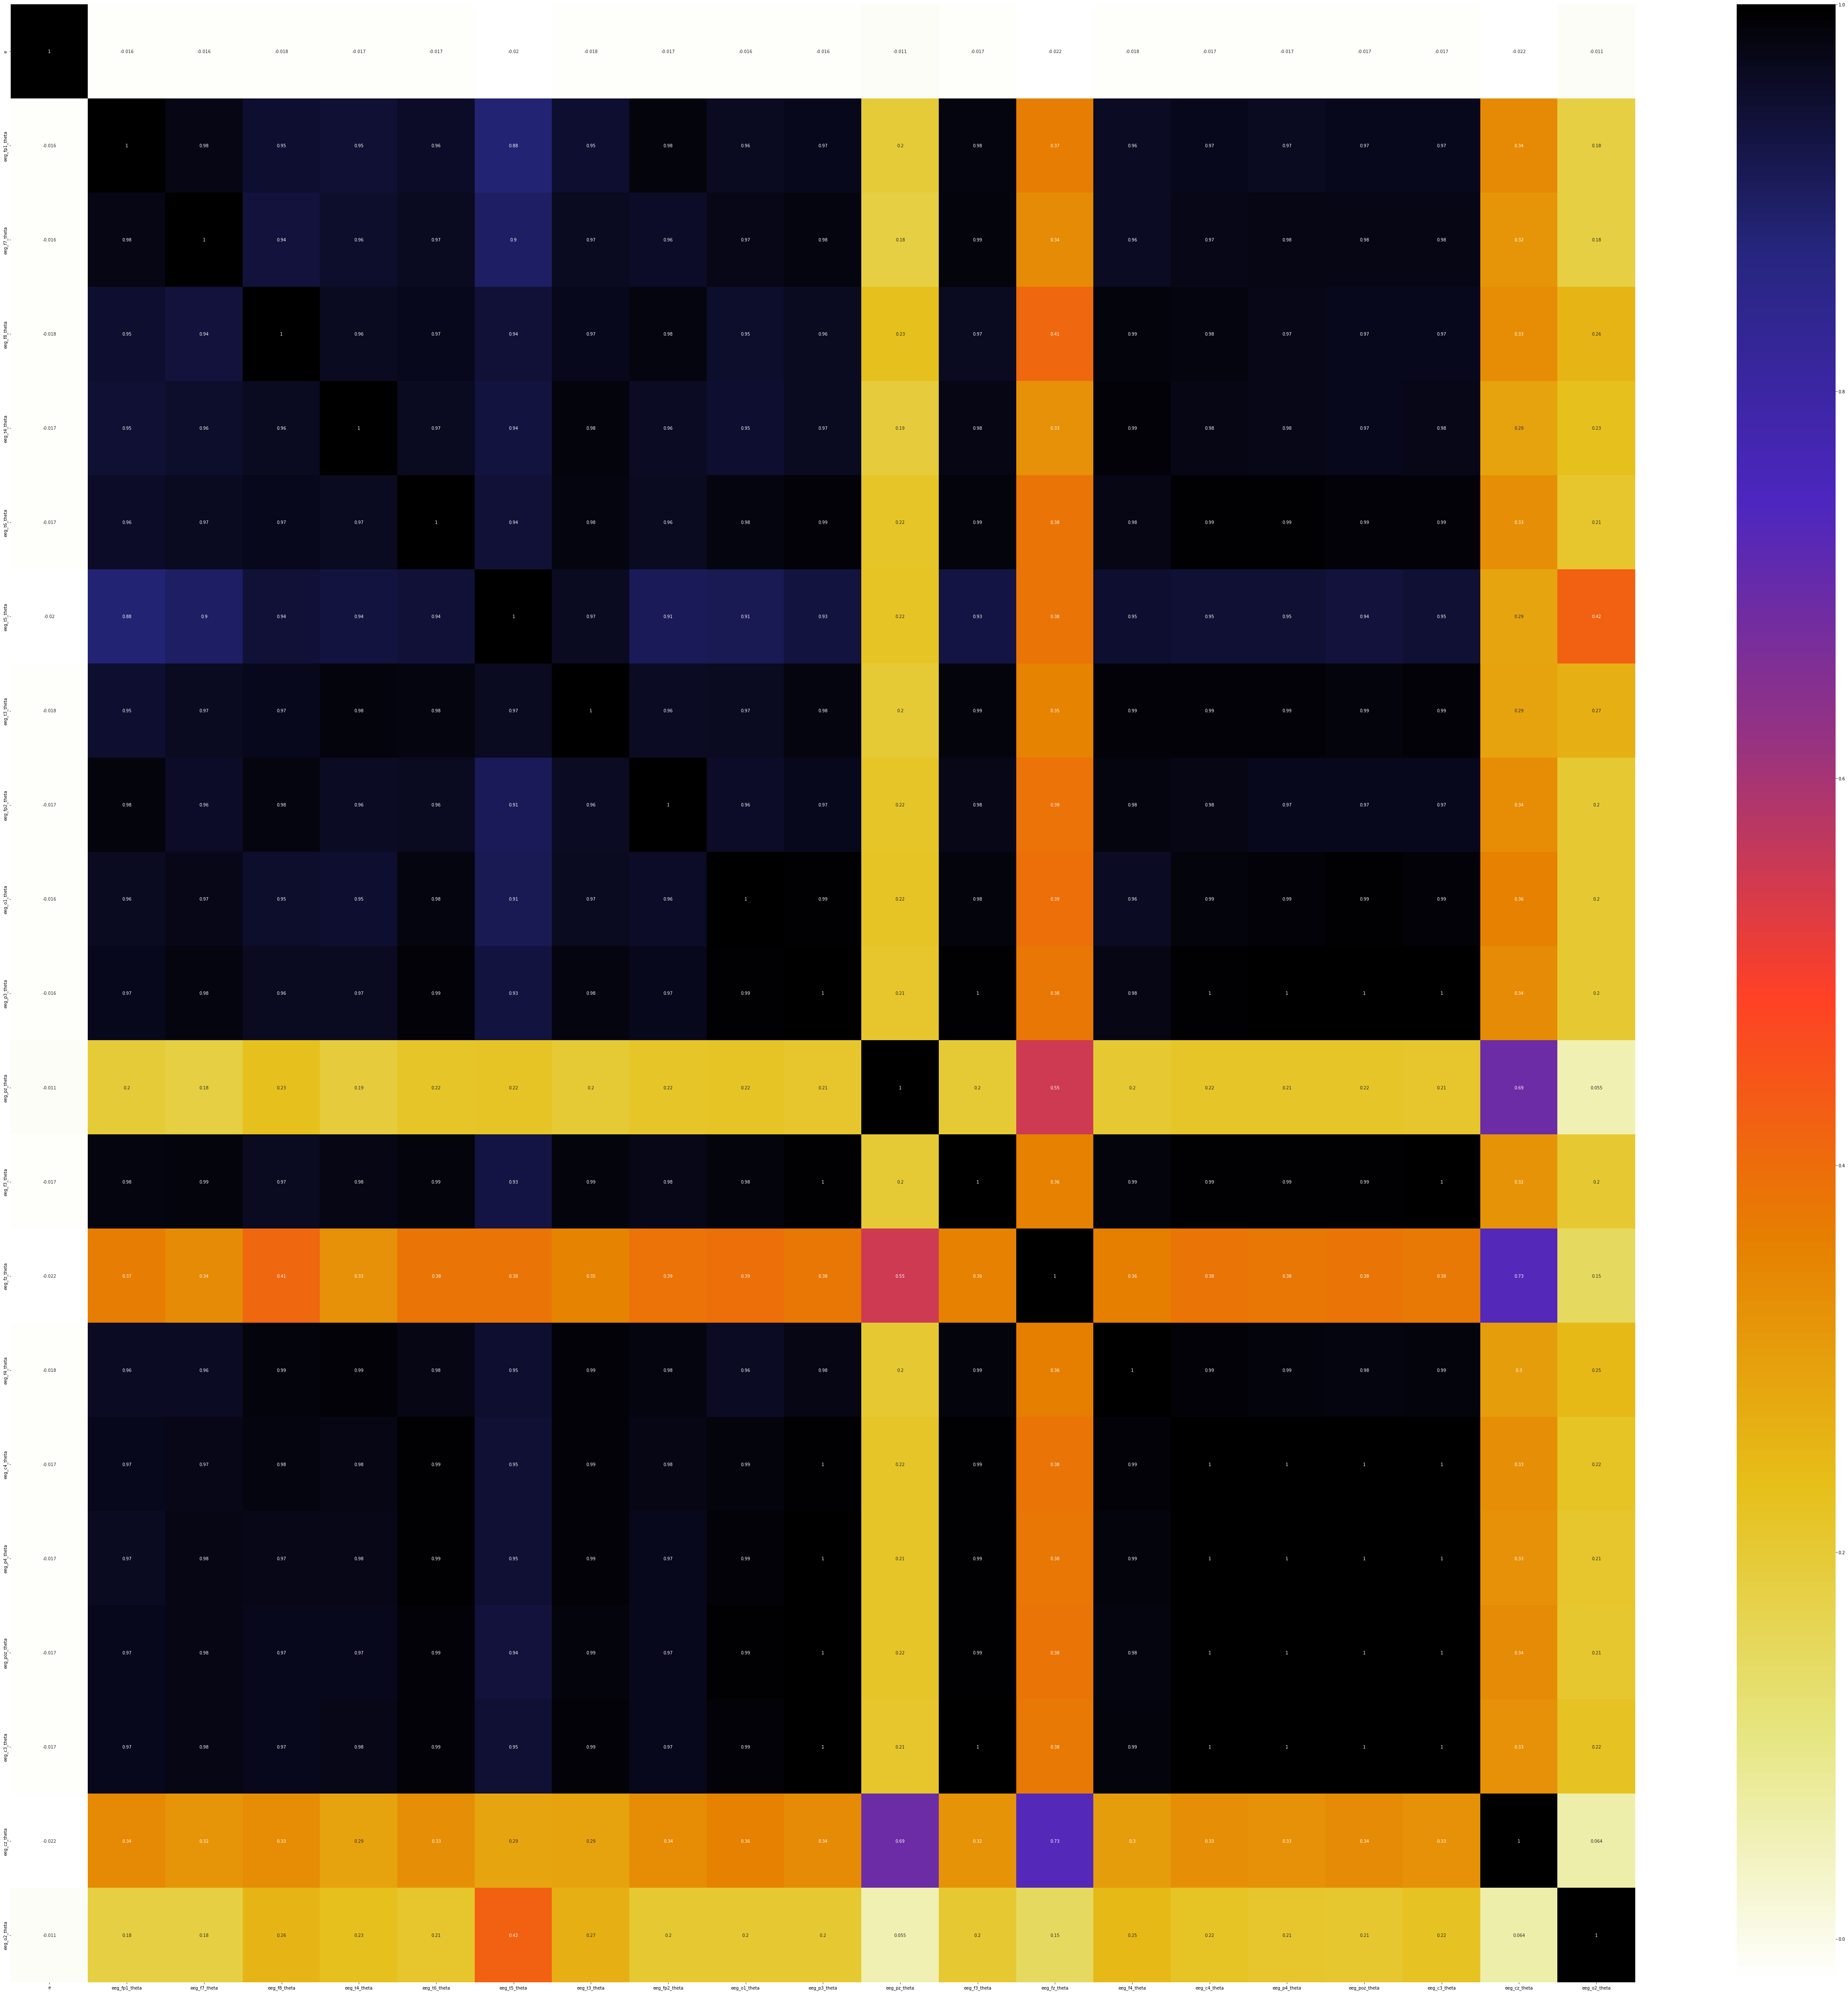

In [102]:
#correlation between theta frequency abnd features and event
theta_feature=[i+"_theta" for i in eeg_features]
g=["e"]
g.extend(theta_feature)
hm = train_data[g].corr()
plt.figure(figsize=(85,85))
sns.heatmap(hm,annot = True, cmap = plt.cm.CMRmap_r)
plt.show()



*   Theta feature's correlation is considerable. So this feature can be useful in predicting the event



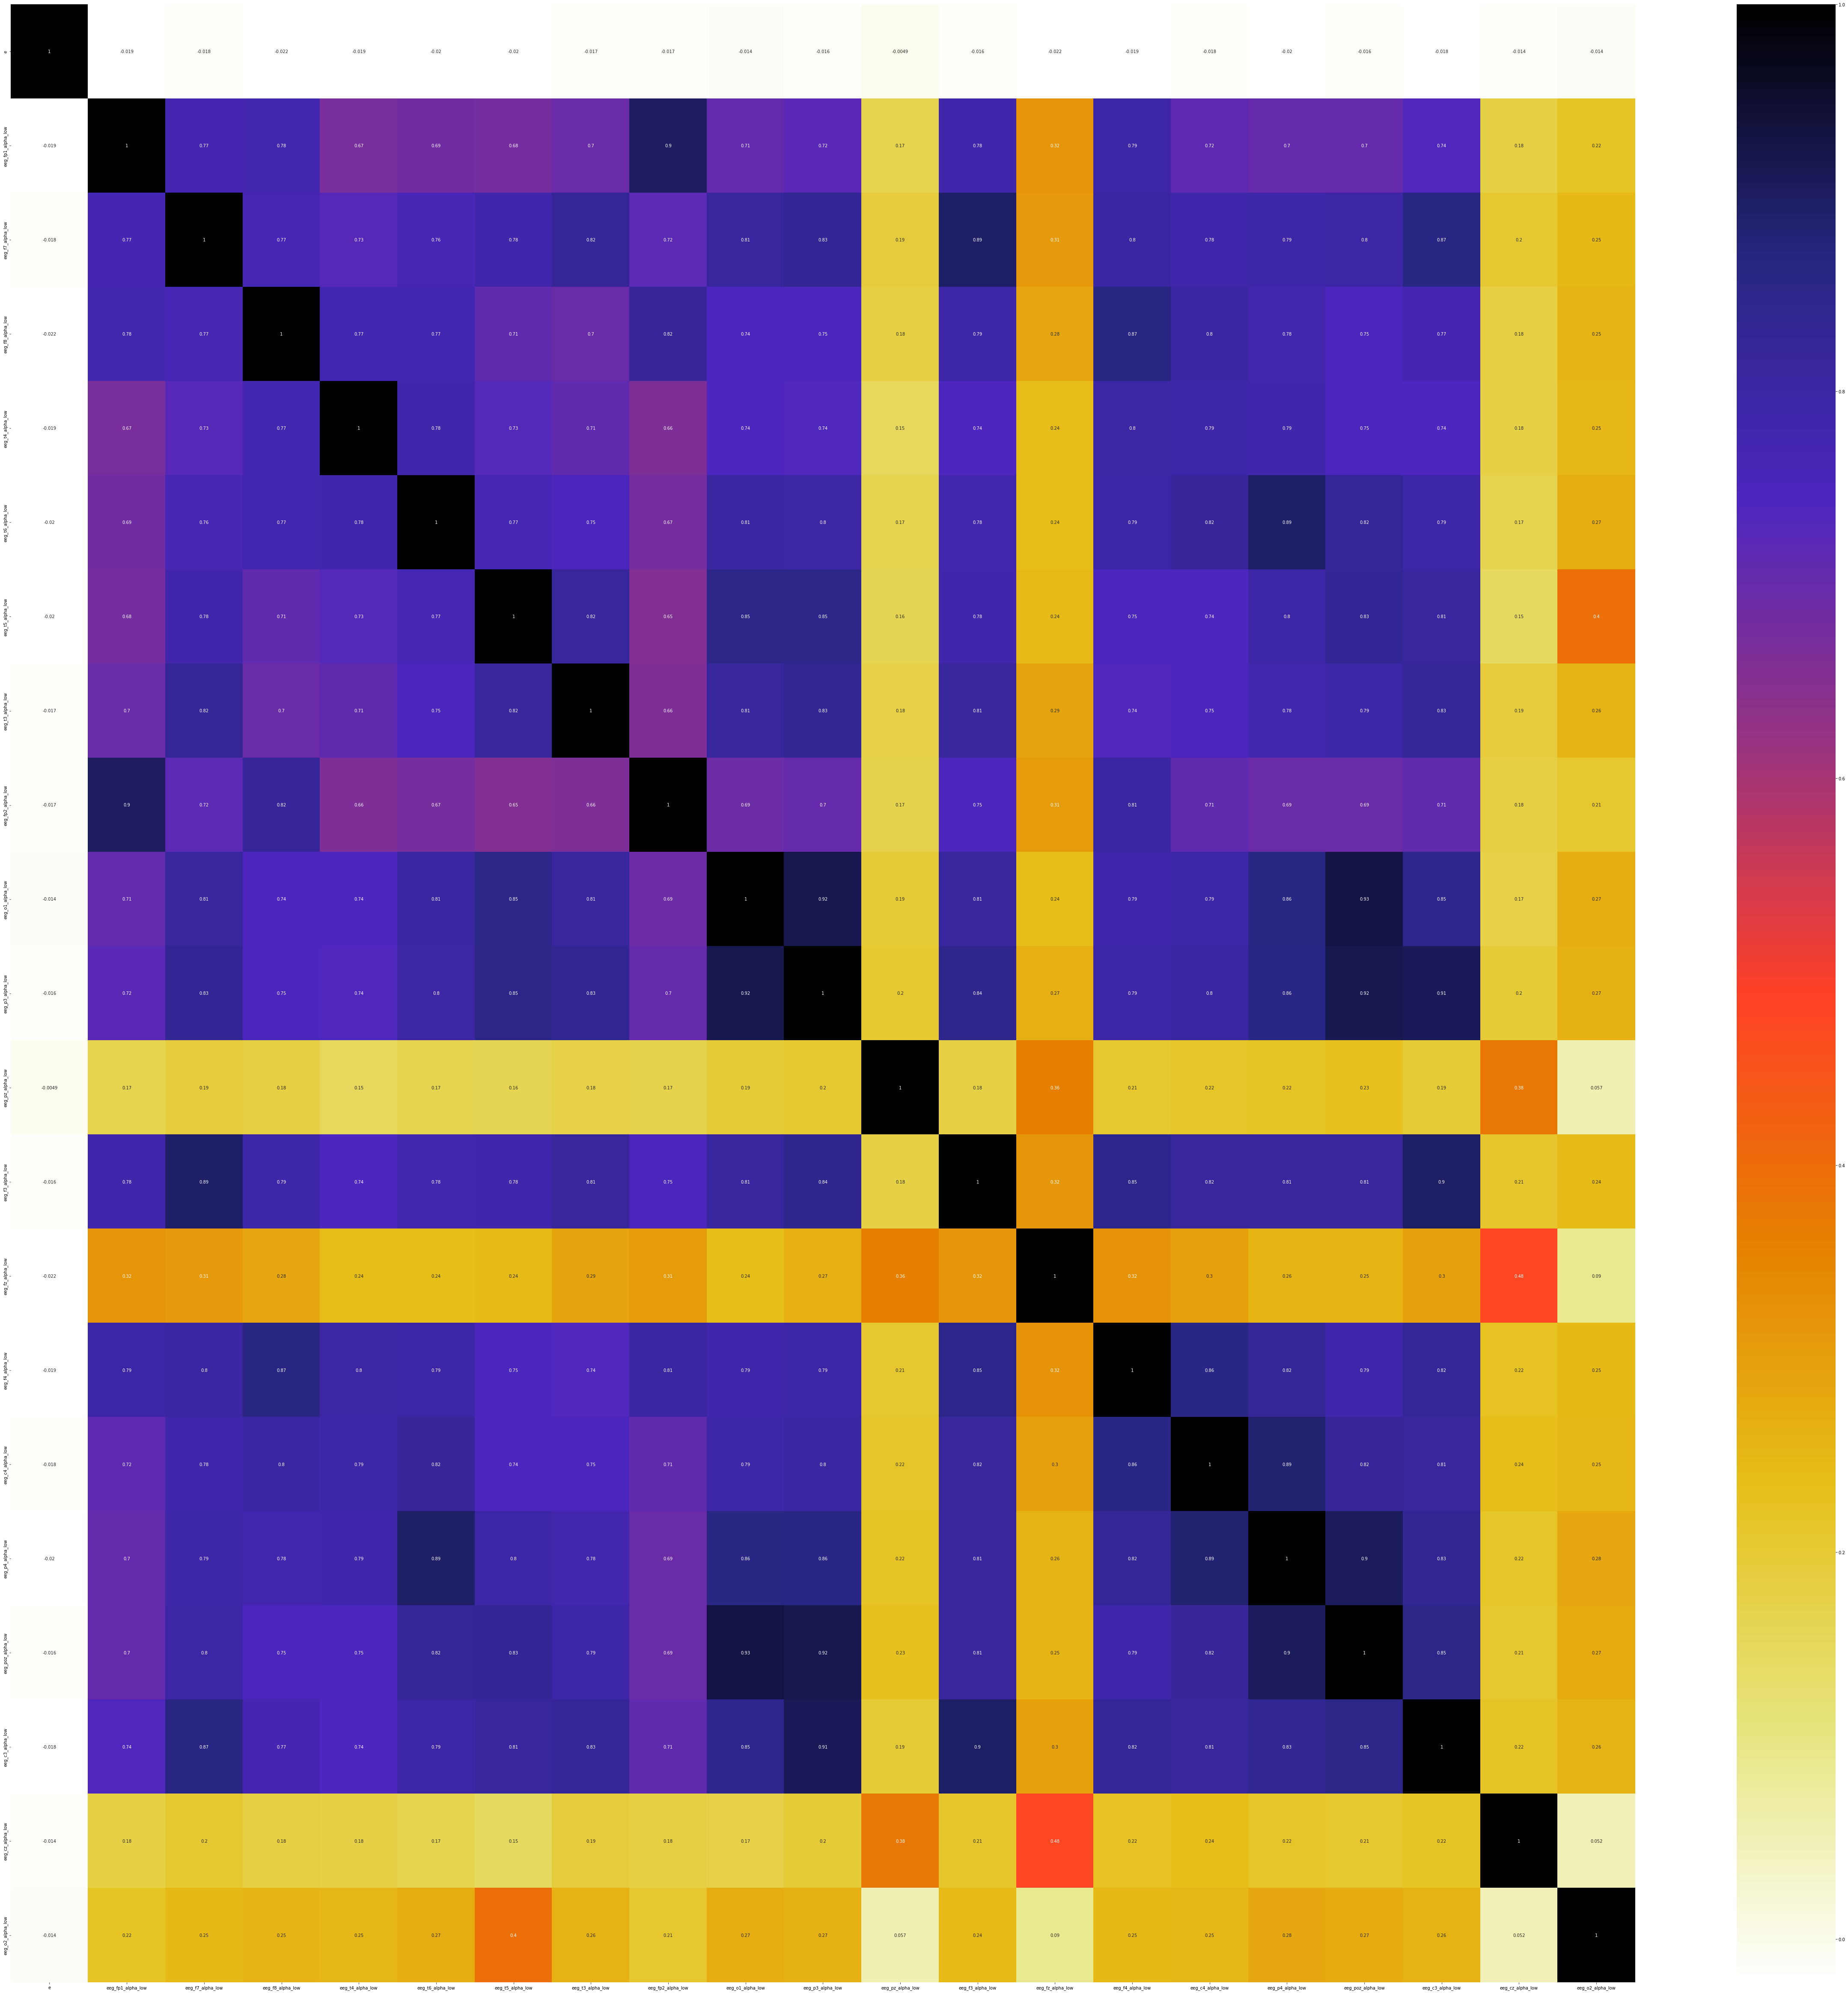

In [103]:
#correlation between alpha low frequency abnd features and event
g=["e"]
g.extend(alpha_low_feature)
hm = train_data[g].corr()
plt.figure(figsize=(85,85))
sns.heatmap(hm,annot = True, cmap = plt.cm.CMRmap_r)
plt.show()



*   From above graph, we can say that may be individually they are not corelated with event, but combined together, it may give good result.


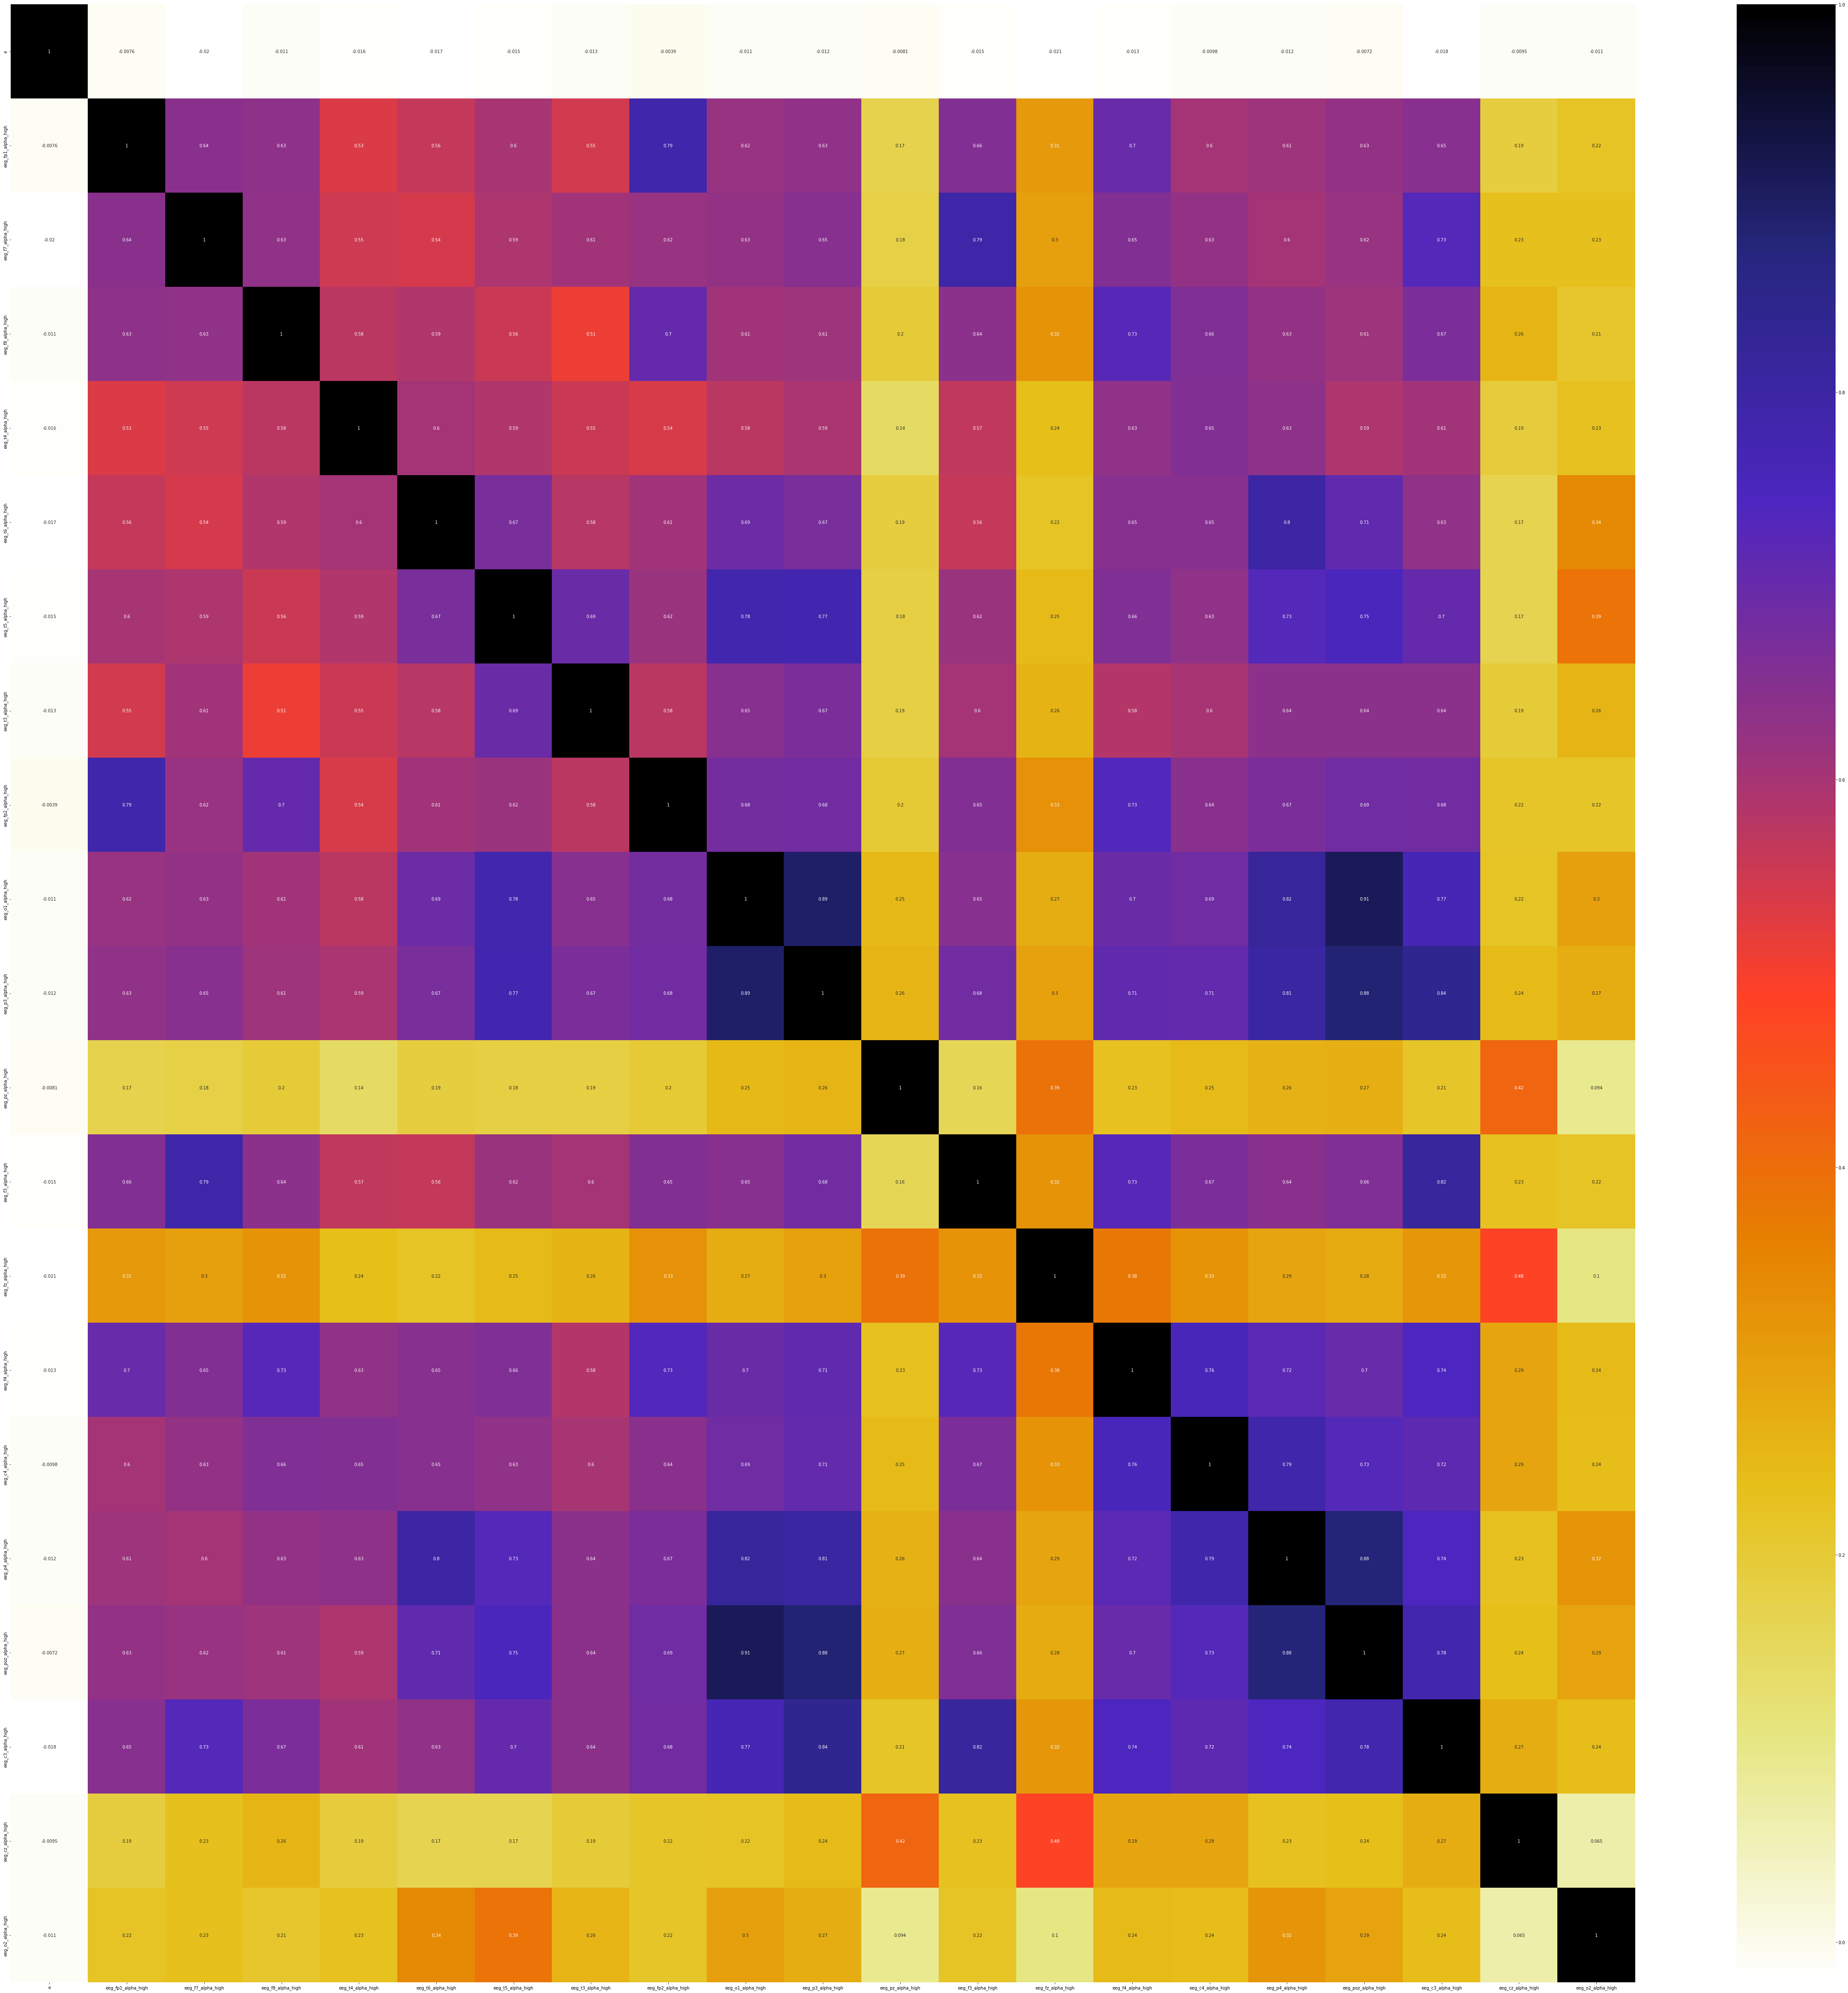

In [104]:
#correlation between alpha high features and event
g=["e"]
g.extend(alpha_high_feature)
hm = train_data[g].corr()
plt.figure(figsize=(85,85))
sns.heatmap(hm,annot = True, cmap = plt.cm.CMRmap_r)
plt.show()




*   From above graph, we can say that may be individually they are not corelated with event, but combined together, it may give good result.


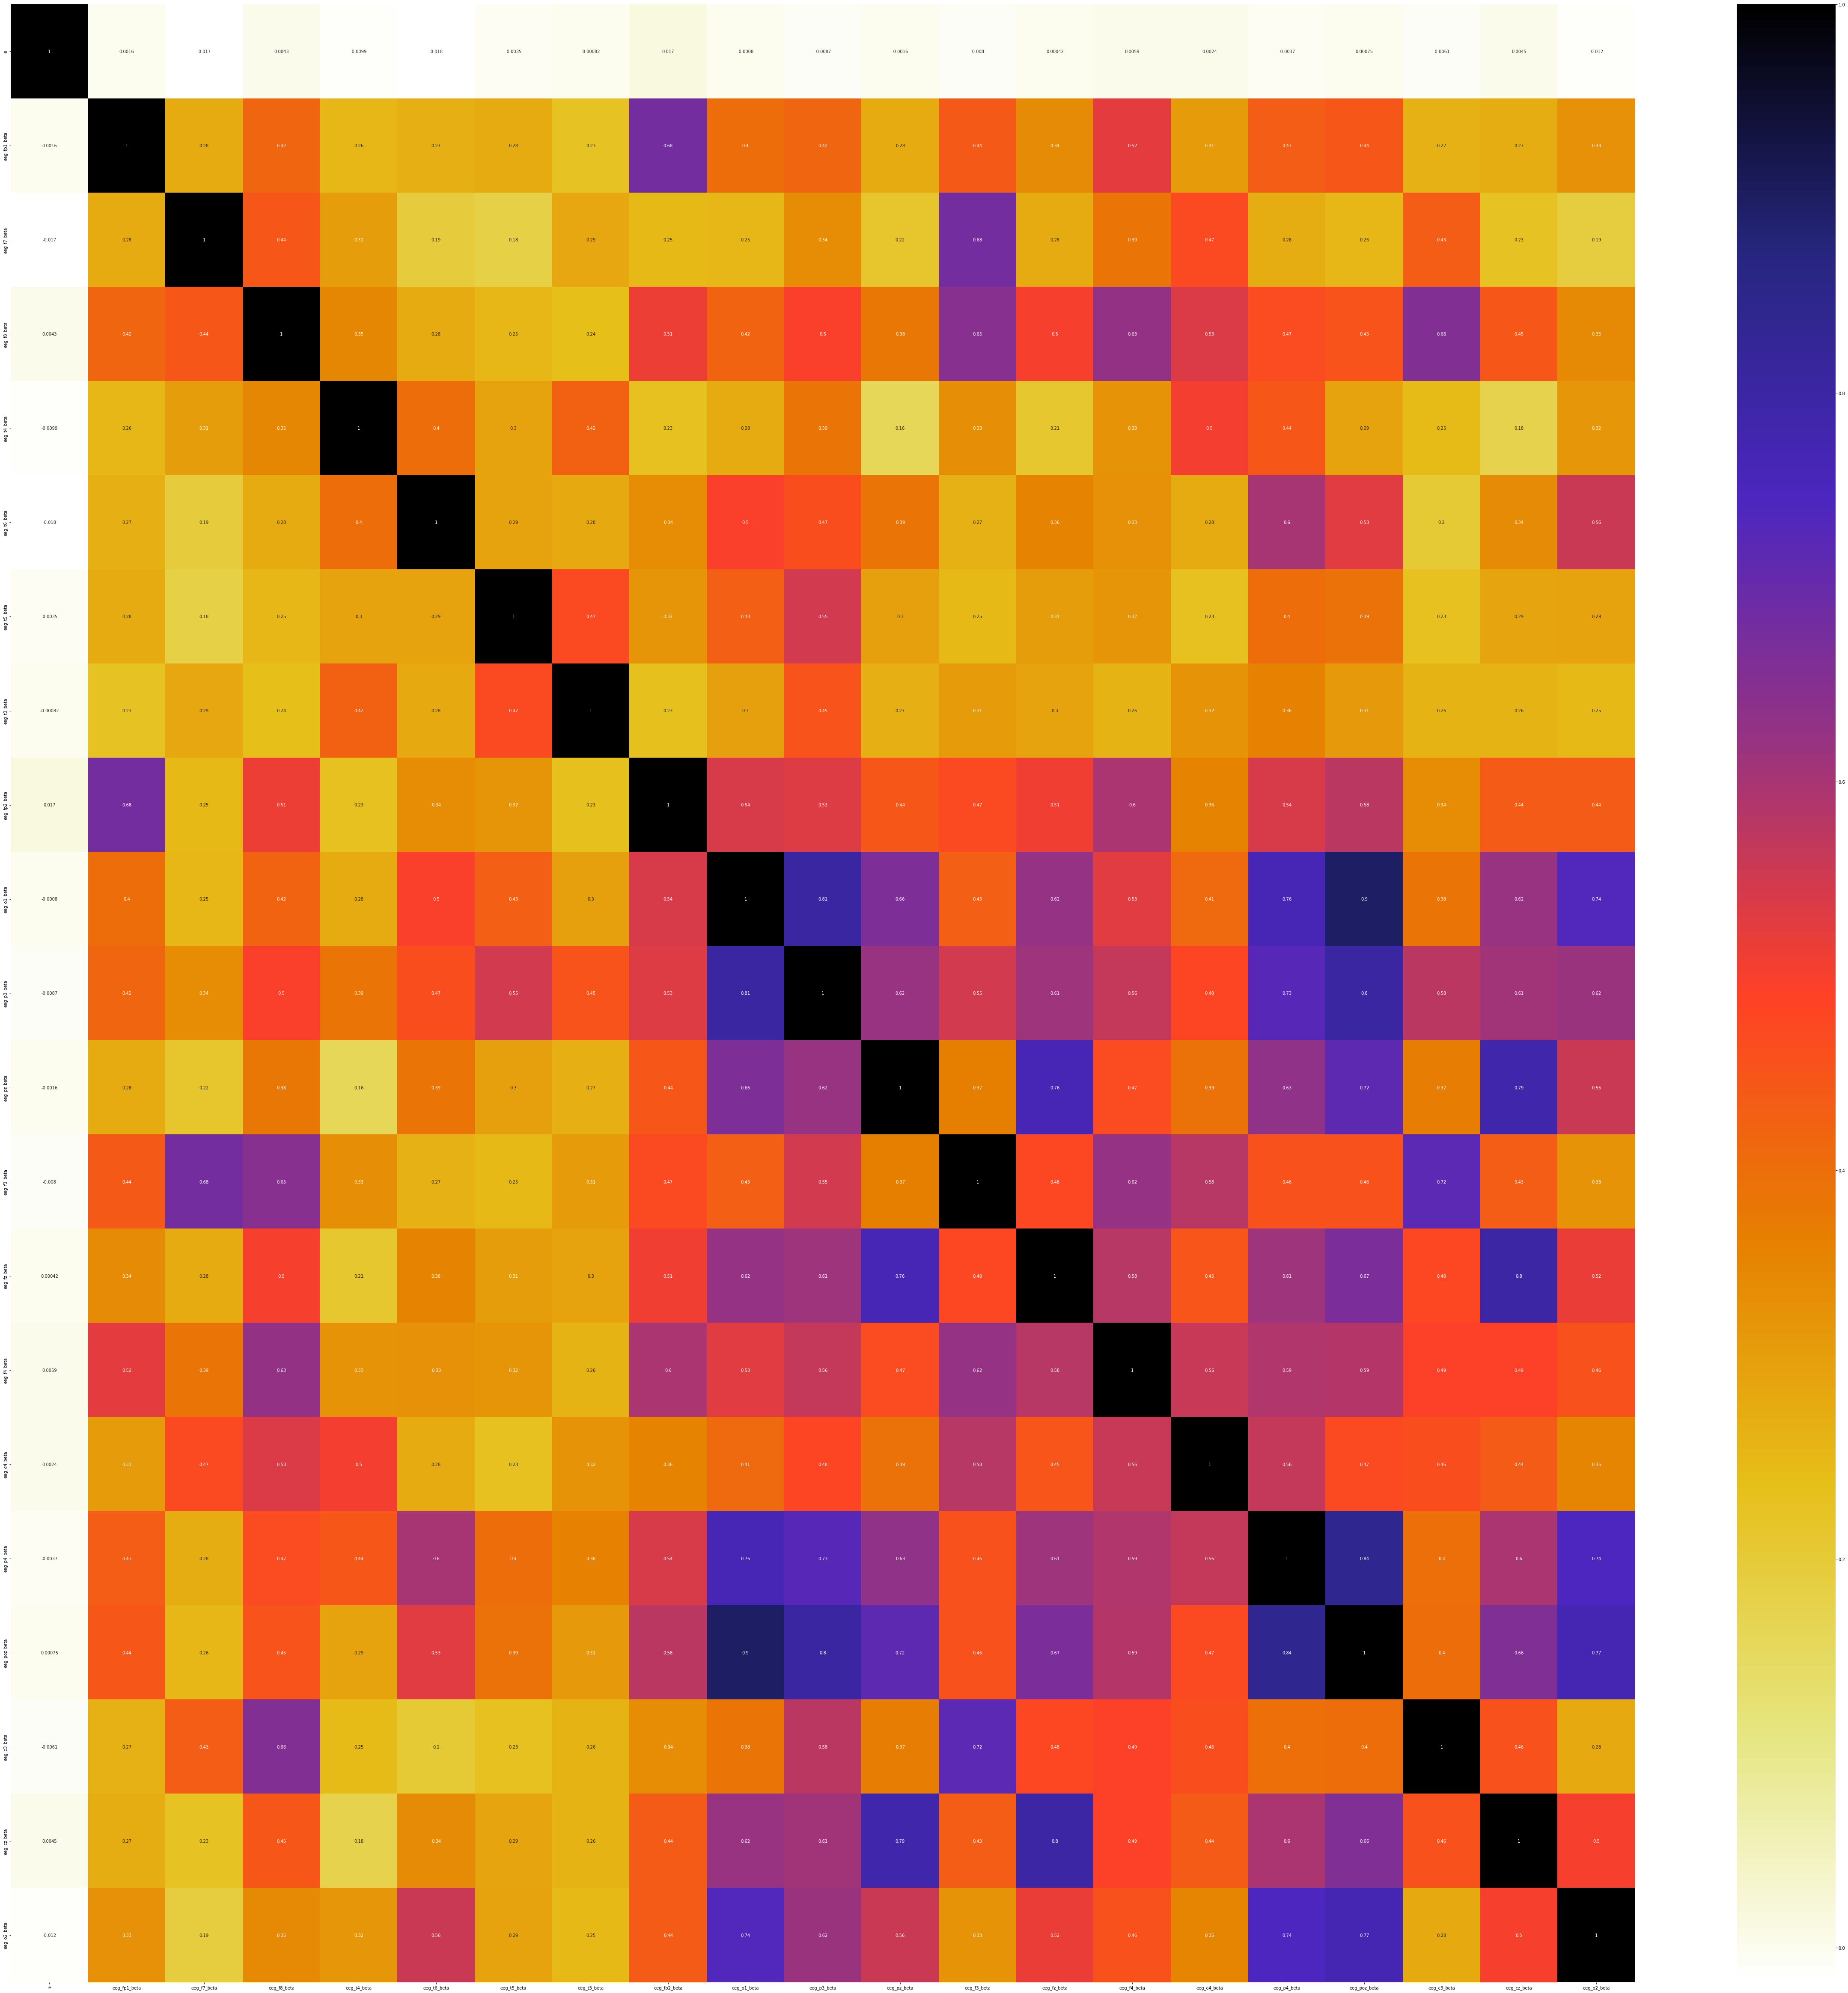

In [105]:
#correlation between beta features and event
beta_feature=[i+"_beta" for i in eeg_features]
g=["e"]
g.extend(beta_feature)
hm = train_data[g].corr()
plt.figure(figsize=(85,85))
sns.heatmap(hm,annot = True, cmap = plt.cm.CMRmap_r)
plt.show()




*   From above graph, we can say that correlation between event and beta columns is not good at all.

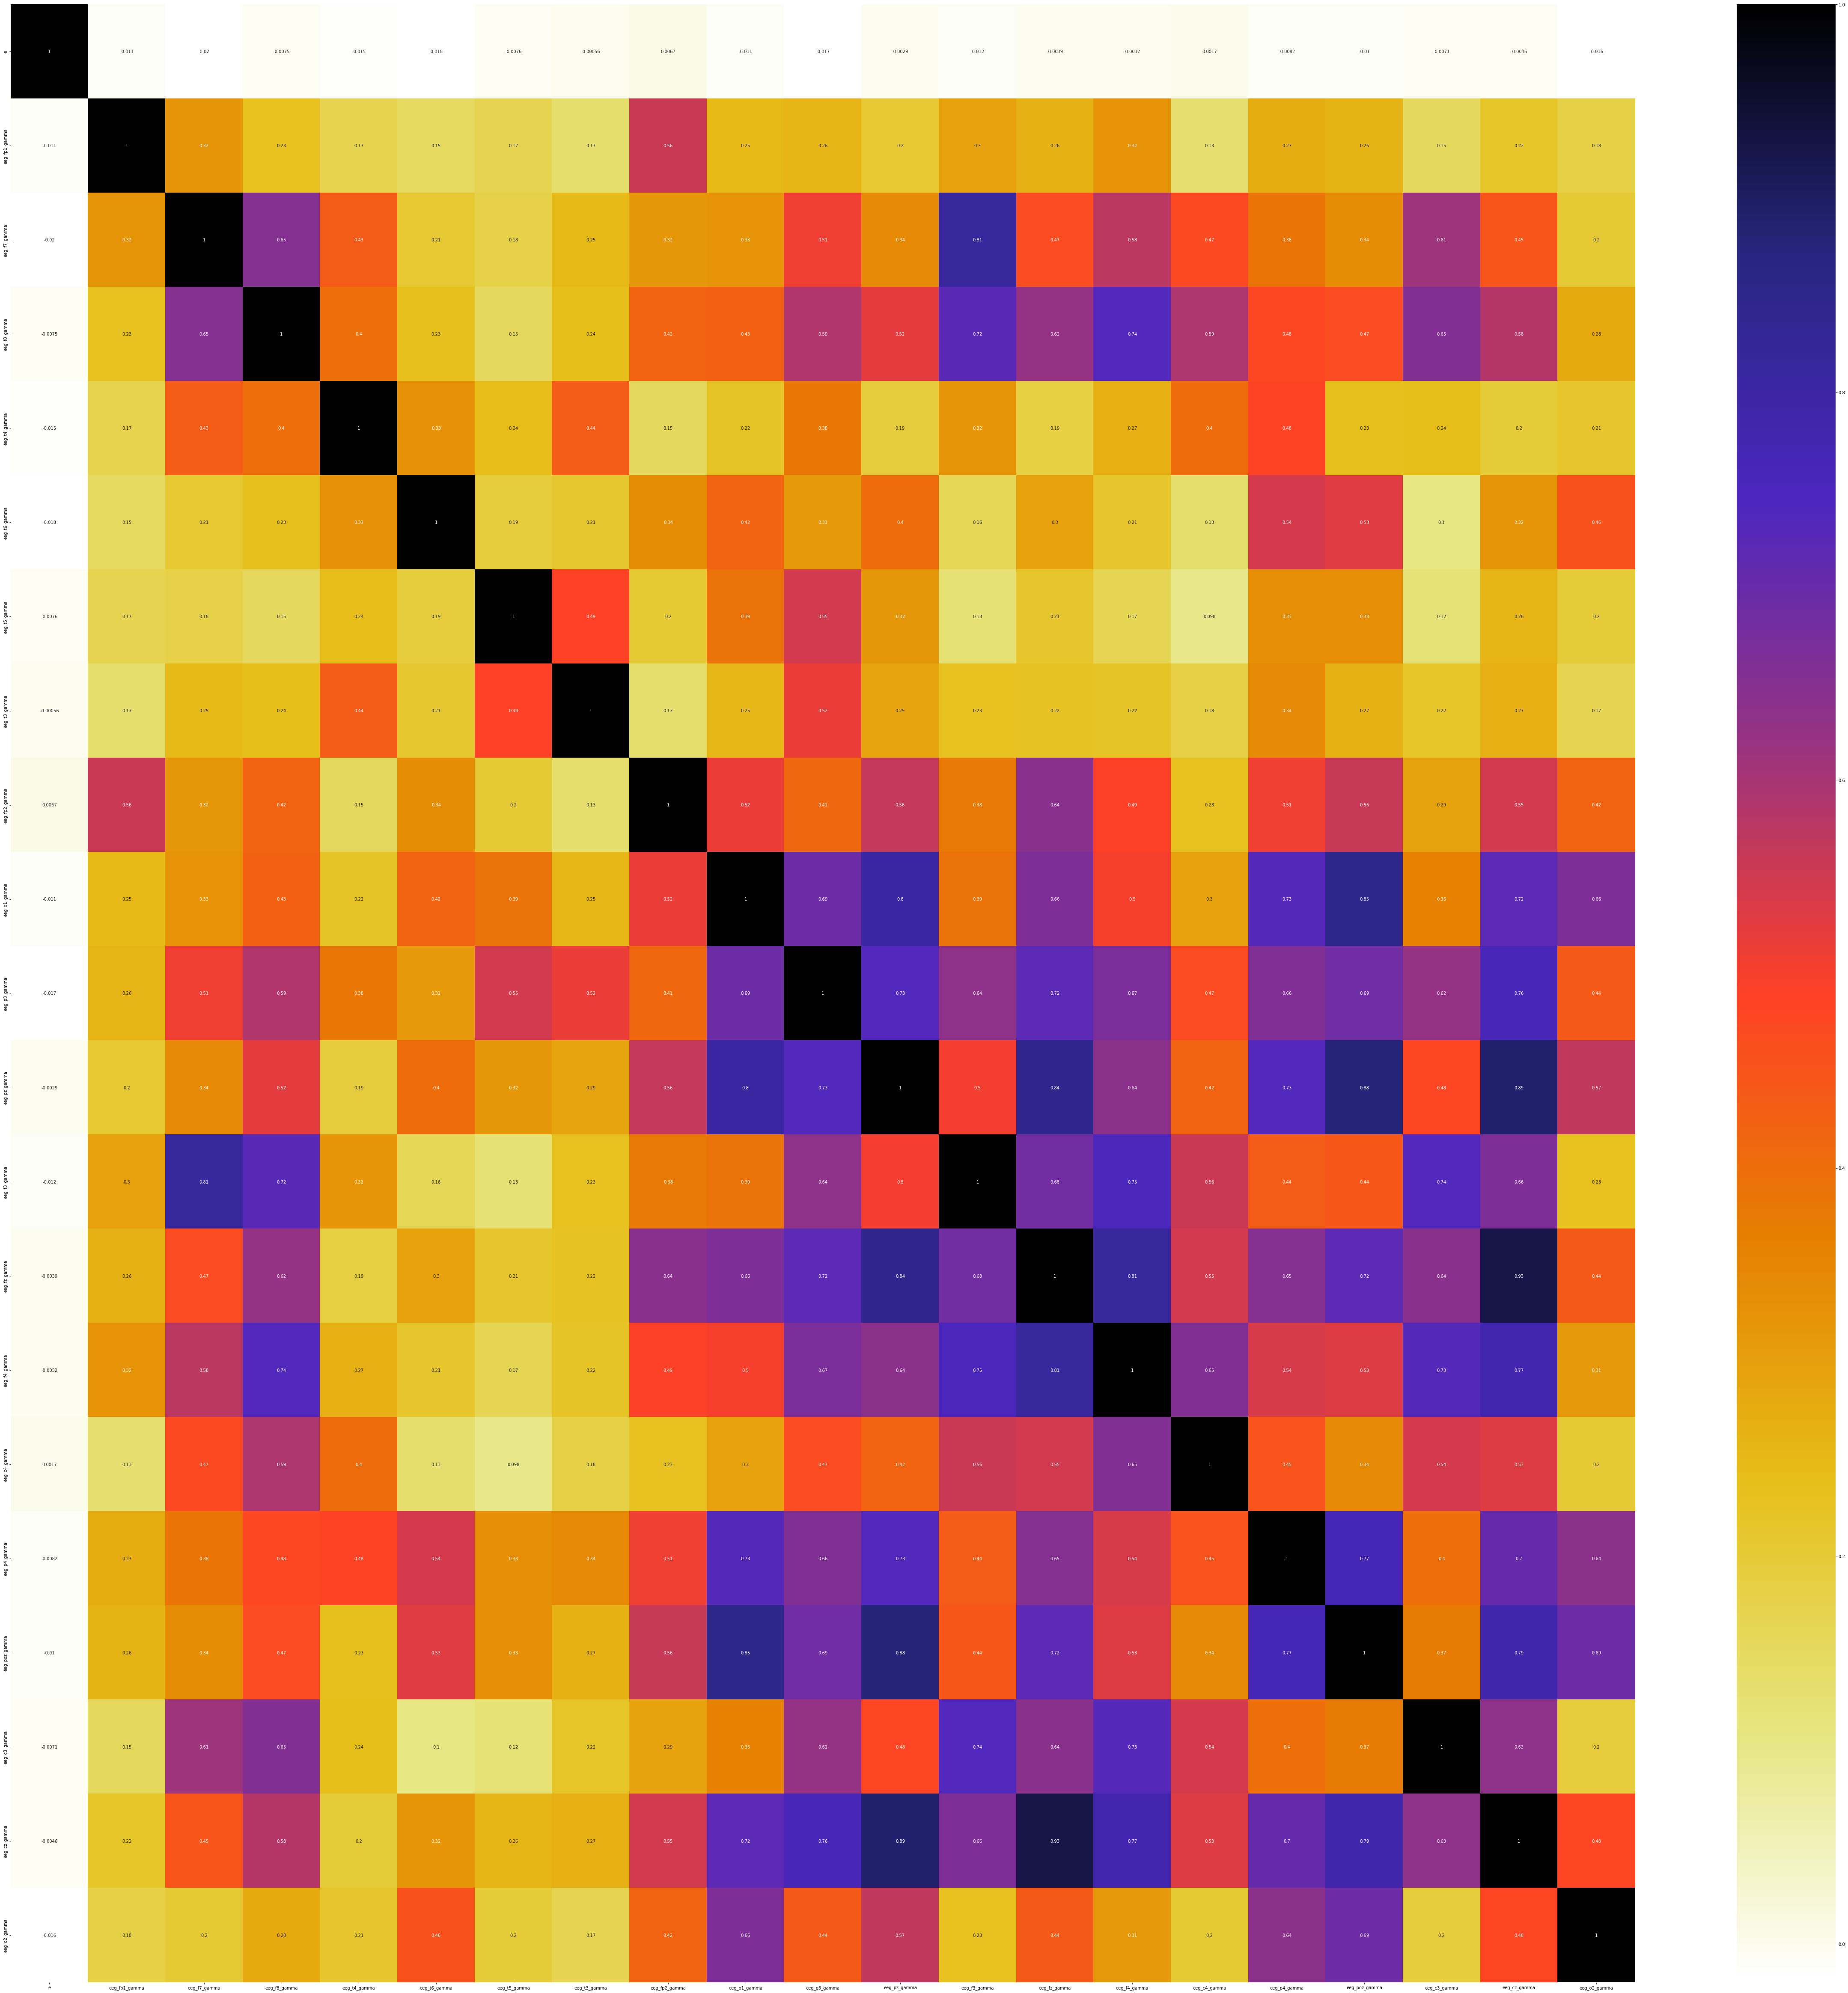

In [106]:
#correlation between gamma features and event
gamma_feature=[i+"_gamma" for i in eeg_features]
g=["e"]
g.extend(gamma_feature)
hm = train_data[g].corr()
plt.figure(figsize=(85,85))
sns.heatmap(hm,annot = True, cmap = plt.cm.CMRmap_r)
plt.show()

 From above graph, we can say that correlation between event and gamma columns is not good at all.




###Removing unimportant dataset

In [24]:
train_data=train_data.drop(["seat","experiment",'event'],axis=1) # removing seat,experiment

beta_feature=[i+"_beta" for i in eeg_features]# removing beta features
train_data=train_data.drop(beta_feature,axis=1)

gamma_feature=[i+"_gamma" for i in eeg_features]# removing gamma features
train_data=train_data.drop(gamma_feature,axis=1)

In [25]:
train_data.columns

Index(['crew', 'time', 'eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6',
       'eeg_t5', 'eeg_t3', 'eeg_fp2',
       ...
       'eeg_f3_alpha_high', 'eeg_fz_alpha_high', 'eeg_f4_alpha_high',
       'eeg_c4_alpha_high', 'eeg_p4_alpha_high', 'eeg_poz_alpha_high',
       'eeg_c3_alpha_high', 'eeg_cz_alpha_high', 'eeg_o2_alpha_high', 'e'],
      dtype='object', length=106)

In [26]:
# Saving after removal of unwanted features
train_data.to_csv("/content/drive/MyDrive/AviationFatalities/feature_eng_train.csv") 